<a href="https://colab.research.google.com/github/gabrielsolucena/portfolio/blob/main/1_MachineLearning_AnuncioFacebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Algoritmo de Machine Learning para definição de estratégia de investimento em anúncios no Facebook de acordo com o perfil de interesse da campanha e com seus objetivos de conversão!  

Esse notebook utiliza dados encontrados em: https://www.kaggle.com/loveall/clicks-conversion-tracking (Acesso em Jul. 2021)

Resumo:

O objetivo deste trabalho é realizar uma previsão do valor de investimento necessário para se converter uma determinada quantidade de visualizações em interesse de compra. Além disso, durante o processo, análisaremos estatísticamente os dados a fim de tirarmos algumas conclusões deles.
Os dados foram gerados em uma campanha real de uma startup anônima.

Minha intenção com esse trabalho é exercitar as bibliotecas envolvidas no processo e desenvolver minha visão análitica em dados de negócios.

##Importação das bibliotecas e classes que serão utilizadas no modelo.

In [1]:
#Manipulação dos dados
import pandas as pd

#Visualização dos Dados
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(context='notebook', color_codes=True) #Define um tema único para todos os plots gráficos do seaborn

#Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#Avaliação do Modelo
from sklearn.metrics import r2_score

##Carregamento do dataframe; Inspeção dos dados; Modificações preliminares; Dicionário dos dados.

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dadosFacebook/KAG_conversion_data.csv")
df.head()

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1


Checando a presença de dados faltantes:

In [3]:
df.isnull().sum()

ad_id                  0
xyz_campaign_id        0
fb_campaign_id         0
age                    0
gender                 0
interest               0
Impressions            0
Clicks                 0
Spent                  0
Total_Conversion       0
Approved_Conversion    0
dtype: int64

Não temos valores nulos

Conversão dos títulos das colunas para facilitar a manipulação:

In [4]:
df.columns = ['id_anuncio','id_campanha','id_facebook','idade','genero','categoria','visualizacoes','cliques','preco_anuncio','interesses','compras']
df.head()

,id_anuncio,id_campanha,id_facebook,idade,genero,categoria,visualizacoes,cliques,preco_anuncio,interesses,compras
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1


Adicionarei três colunas ao nosso dataframe. 

A primeira é uma coluna de conversão em cliques. Ela nos apresenta em valor percentuais quantas pessoas clicaram no anúncio após a sua visualização.

A segunda é uma coluna de conversão em interesses. Ela nos apresenta em valor percentuais quantas pessoas se interessaram pelo produto em relação ao número de visualizações.

A terceira é uma coluna de conversão em compras. Ela nos apresenta em valor percentuais quantas pessoas de fato compraram o produto após a visualização do anúncio.

Minha intenção ao adicionar essas colunas é estudar a possível relação entre elas, e como essas relação pode nos ajudar a formular um modelo de previsão mais eficiente.

In [5]:
df['conv_cliques'] = df.apply(lambda x: x['cliques'] / x['visualizacoes'], axis = 1)
df['conv_interesses'] = df.apply(lambda x: x['interesses'] / x['visualizacoes'], axis = 1)
df['conv_compras'] = df.apply(lambda x: x['compras'] / x['visualizacoes'], axis = 1)
df.head()

,id_anuncio,id_campanha,id_facebook,idade,genero,categoria,visualizacoes,cliques,preco_anuncio,interesses,compras,conv_cliques,conv_interesses,conv_compras
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1,0.000136,0.000272,0.000136
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0,0.000112,0.000112,0.000000
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0,0.000000,0.001443,0.000000
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0,0.000235,0.000235,0.000000
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1,0.000242,0.000242,0.000242


Dicionário dos dados:
1. id_anuncio - Identificação única do anúncio específico.
2. id_campanha - Identificação da campanha à qual o anúncio faz parte.
3. id_facebook - Identificação de rastreio do Facebook.
4. idade - Grupo de idade para o qual o anúncio foi mostrado.
5. genero - Gênero da pessoa para o qual o anúncio foi mostrado.
6. catergoria - Código da categoria de interesse à qual a pessoa alvo do anúncio pertencia. (Segmentação realizada pelo Facebook)
7. visualizacoes - Número de vezes que o anúncio foi visualizado.
8. cliques - Número de vezes que clicaram no anúncio.
9. preco_anuncio - Valor pago pela empresa ao Facebook para exibir o anúncio.
10. interesses - Número de pessoas que demonstraram real interesse no produto após o anúncio.
11. compras - Número de pessoas que compraram o produto após o anúncio.
12. conv_cliques - porcentagem de conversão de visualizações em cliques.
13. conv_compras - porcentagem de conversão de visualizações em compras.
14. conv_interesses - porcentagem de conversão de visualizações em interesse.


##Análise estátistica dos dados voltada para o desenvolvimento do modelo.

Abriremos os dados em seus principais valores estatísticos afim de entender melhor o seu comportamento:

In [6]:
df.describe(include='all')

,id_anuncio,id_campanha,id_facebook,idade,genero,categoria,visualizacoes,cliques,preco_anuncio,interesses,compras,conv_cliques,conv_interesses,conv_compras
count,1.143000e+03,1143.000000,1143.000000,1143,1143,1143.000000,1.143000e+03,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
unique,NaN,NaN,NaN,4,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,30-34,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,426,592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.872611e+05,1067.382327,133783.989501,NaN,NaN,32.766404,1.867321e+05,33.390201,51.360656,2.855643,0.944007,0.000164,0.000253,0.000102
std,1.939928e+05,121.629393,20500.308622,NaN,NaN,26.952131,3.127622e+05,56.892438,86.908418,4.483593,1.737708,0.000115,0.000712,0.000566
min,7.087460e+05,916.000000,103916.000000,NaN,NaN,2.000000,8.700000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.776325e+05,936.000000,115716.000000,NaN,NaN,16.000000,6.503500e+03,1.000000,1.480000,1.000000,0.000000,0.000100,0.000012,0.000000
50%,1.121185e+06,1178.000000,144549.000000,NaN,NaN,25.000000,5.150900e+04,8.000000,12.370000,1.000000,1.000000,0.000160,0.000031,0.000001
75%,1.121804e+06,1178.000000,144657.500000,NaN,NaN,31.000000,2.217690e+05,37.500000,60.025000,3.000000,1.000000,0.000234,0.000169,0.000011


Farei aqui a primeira intervenção importante nos dados. Como podemos ver, as colunas 'cliques', 'preco_anuncio', 'interesses' e 'compras' apresentam valores mínimos aparentemente igual a zero. Como uma campanha de marketing não tem interesse por resultados iguais a zero, não é interessante que o nosso modelo aprenda com eles. Isso pode viciar o nosso modelo.

Portanto irei retirar esses valores:

In [7]:
df = df[df['cliques']>0]
df = df[df['preco_anuncio']>0]
df = df[df['interesses']>0]
df = df[df['compras']>0]
df.describe(include='all')

,id_anuncio,id_campanha,id_facebook,idade,genero,categoria,visualizacoes,cliques,preco_anuncio,interesses,compras,conv_cliques,conv_interesses,conv_compras
count,5.130000e+02,513.000000,513.000000,513,513,513.000000,5.130000e+02,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,5.130000e+02
unique,NaN,NaN,NaN,4,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,30-34,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,180,270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.059547e+06,1116.994152,141164.354776,NaN,NaN,35.758285,3.195538e+05,55.230019,85.674093,4.711501,1.955166,0.000189,0.000052,4.171601e-05
std,1.771503e+05,105.957621,19828.683488,NaN,NaN,30.529955,3.951735e+05,69.387173,106.837682,6.109243,2.174052,0.000085,0.000085,8.152948e-05
min,7.087460e+05,916.000000,103916.000000,NaN,NaN,2.000000,2.077000e+03,1.000000,0.180000,1.000000,1.000000,0.000033,0.000002,7.367101e-07
25%,1.121091e+06,1178.000000,144531.000000,NaN,NaN,16.000000,3.508800e+04,6.000000,9.230000,1.000000,1.000000,0.000134,0.000011,4.448517e-06
50%,1.121469e+06,1178.000000,144602.000000,NaN,NaN,25.000000,1.647540e+05,26.000000,38.630000,2.000000,1.000000,0.000169,0.000019,8.411702e-06
75%,1.121962e+06,1178.000000,144684.000000,NaN,NaN,32.000000,4.525190e+05,80.000000,124.800000,5.000000,2.000000,0.000229,0.000045,3.185424e-05


Podemos notar que nas colunas 'cliques' e 'visualizacoes' os valores de desvio padrão estão muito elevados. Além disso, a diferença entre o valor máximo dessas colunas e o valor de terceiro quartil é muito grande. Isso é um sinal de possíveis outliers. 

Como a nossa intenção é avaliar a influência destas variáveis no preço do anúncio e realizar a previsão pelo método da regressão linear. Abrirei ambas em função da coluna 'preco_anuncio' para analisar a real existência e a possível discrepância destes outliers:

Cliques em função do preço do anúncio:

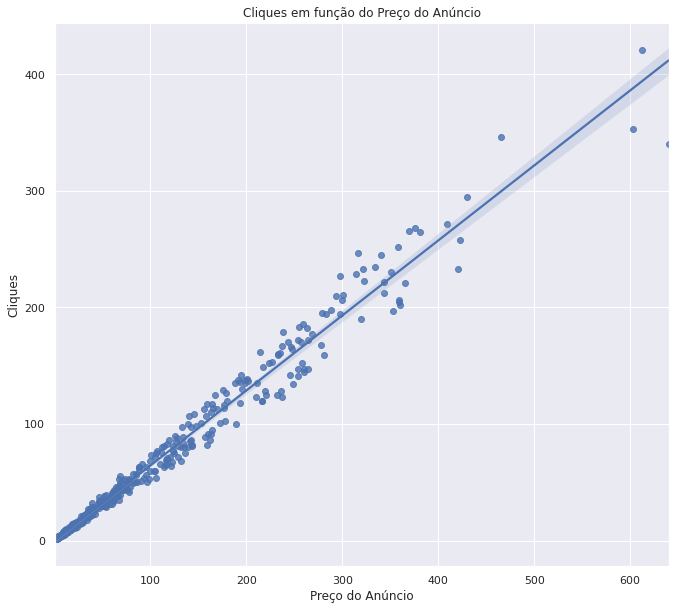

In [8]:
f, ax = plt.subplots(figsize=(11, 10))
sns.regplot(x="preco_anuncio", y="cliques", data=df, ax=ax)
plt.title("Cliques em função do Preço do Anúncio")
plt.xlabel("Preço do Anúncio")
plt.ylabel("Cliques")
plt.show()

Visualizações em função do preço do anúncio:

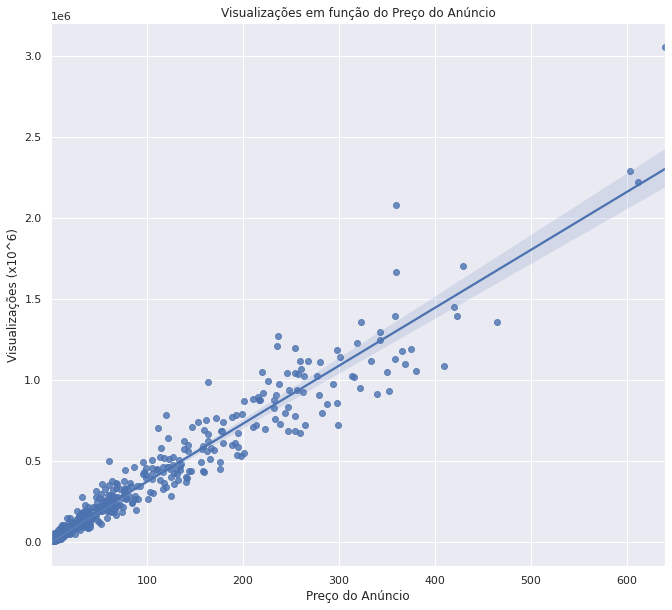

In [9]:
f, ax = plt.subplots(figsize=(11, 10))
sns.regplot(x="preco_anuncio", y="visualizacoes", data=df, ax=ax)
plt.title("Visualizações em função do Preço do Anúncio")
plt.xlabel("Preço do Anúncio")
plt.ylabel("Visualizações (x10^6)")
plt.show()

Notamos que realmente, tanto a coluna 'precos' quanto a coluna 'visualizacoes' apresentam uma grande frequência de valores baixos e poucos valores altos que podem ser considerados como outliers. Porém, quando abrimos essas colunas em função do preço do anúncio, vemos que eles não se afastam tanto da reta de regressão linear, e que portanto não terão uma influência negativa em nosso método.

Dando continuidade em nossa análise, veremos quais váriaveis apresentam maior correlação com a nossa váriavel-alvo , 'preco_anuncio':

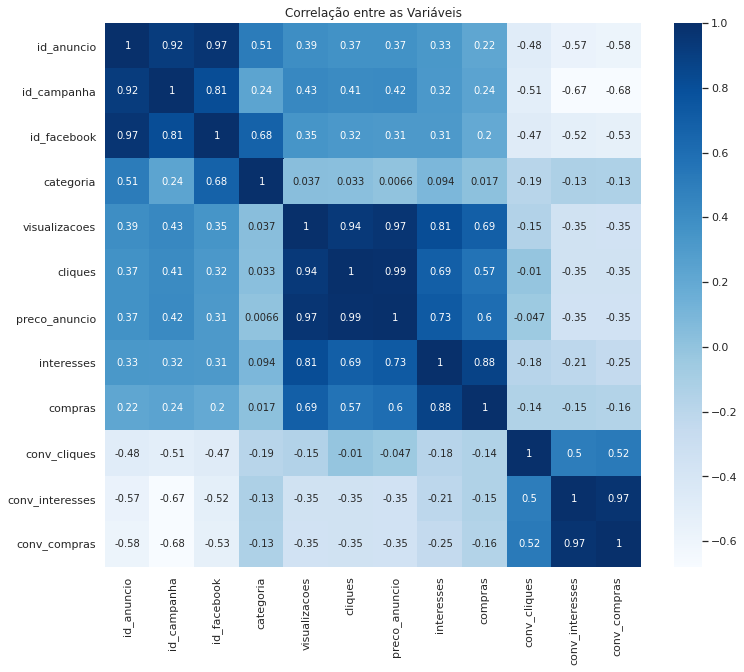

In [10]:
plt.figure(figsize=(12,10))
mat_correl = df.corr()
sns.heatmap(mat_correl, annot=True, cmap=plt.cm.Blues)
plt.title("Correlação entre as Variáveis")
plt.show()

Podemos perceber que a váriavel de maior correlação com 'preco_anuncio' é a 'cliques', seguida de 'visualizacoes'. Justamente as duas variáveis que observamos em maior detalhe anteriormente. 

Outra informação interessante é que as correlações entre a variável 'preco_anuncio' e as variáveis 'conv_interesse' e 'conv_compra' são negativas.

Isso significa que pagar mais caro em um anúncio, pode até significar mais cliques e visualizações, porém, pelo menos percentualmente, não significa um aumento em interesse e compra.

Observemos com mais detalhes essas correlações específicas entre preço e as variáveis de conversão:

Correlação entre Conversão em Interesse e Preço do Anúncio:

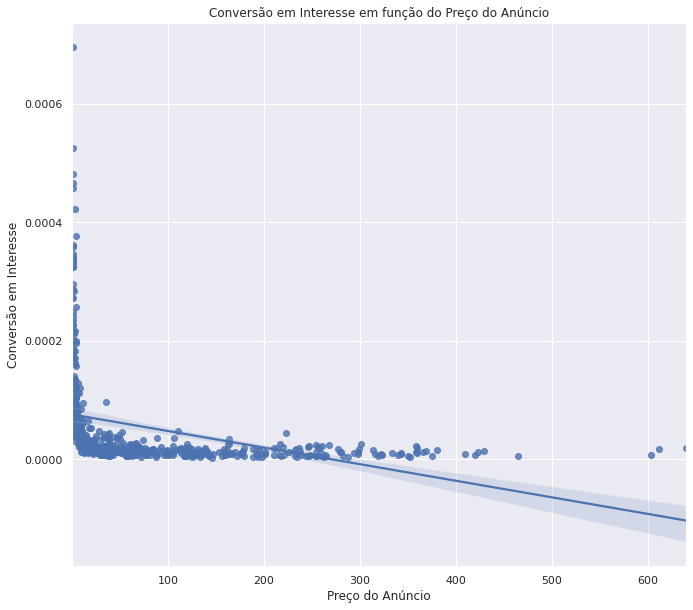

In [11]:
f, ax = plt.subplots(figsize=(11, 10))
sns.regplot(x="preco_anuncio", y="conv_interesses", data=df, ax=ax)
plt.title("Conversão em Interesse em função do Preço do Anúncio")
plt.xlabel("Preço do Anúncio")
plt.ylabel("Conversão em Interesse")
plt.show()

Correlação entre Conversão em Compra e Preço do Anúncio:

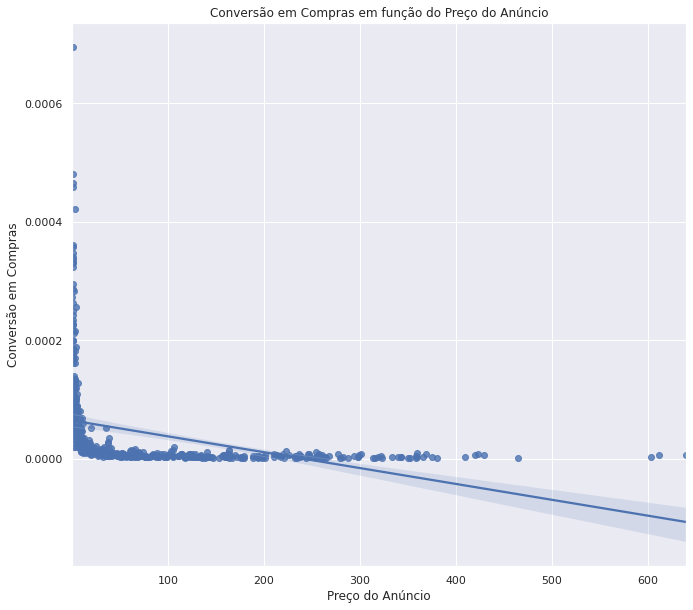

In [12]:
f, ax = plt.subplots(figsize=(11, 10))
sns.regplot(x="preco_anuncio", y="conv_compras", data=df, ax=ax)
plt.title("Conversão em Compras em função do Preço do Anúncio")
plt.xlabel("Preço do Anúncio")
plt.ylabel("Conversão em Compras")
plt.show()

Analizando mais abertamente essa variáveis podemos confirmar o que foi levantado anteriormente. O aumento no preço do anúncio pode até aumentar as visualizações e cliques, porém, não aumenta a conversão da visualização em interesse e compras proporcionalmente!

Analisaremos agora as variáveis 'idade', 'genero' e 'categoria':

Primeiro a idade:

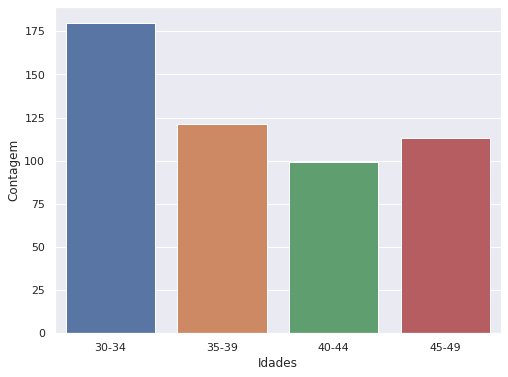

In [13]:
plt.figure(figsize=(8,6))
sns.countplot(x='idade', data=df) 
plt.xlabel("Idades")
plt.ylabel("Contagem")
plt.show()

Como podemos ver, a idade é separada em grupos. Além disso, elas vão de 30 a 49 anos e estão distribuidas igualmente com o grupo 30-34 despontando um pouco.

Gênero:

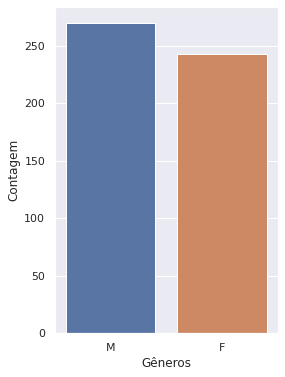

In [14]:
plt.figure(figsize=(4,6))
sns.countplot(x='genero', data=df)
plt.xlabel("Gêneros")
plt.ylabel("Contagem")
plt.show()

Podemos considerar que estão distribuidos igualmente.

Categoria:

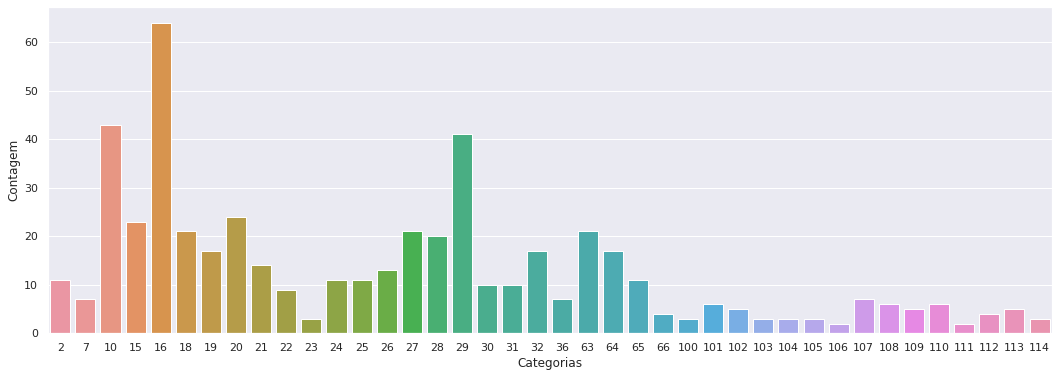

In [15]:
plt.figure(figsize=(18,6))
sns.countplot(x='categoria', data=df) 
plt.xlabel("Categorias")
plt.ylabel("Contagem")
plt.show()

Como podemos ver, a distribuição das categorias não apresenta nenhum padrão. Porém, podemos ver que a categoria 16 apresenta a maior frequência e a 106 a menor. Isso significa que os anúncios foram mais exibidos para a categoria 16 do que para todas as outras e que para a categoria 106 eles foram pouco exibidos.

Finalizamos assim a exploração e entendimento dos dados!

##Decisão de quais variáveis usar no aprendizado e preparação do dataframe com base nas decisões tomadas.

Como minha intenção é elaborar um modelo que preveja o valor correto para se pagar em um anúncio de acordo com a estratégia que a pessoa contratante desejar seguir e com os resultados que desejar obter. Cheguei na seguinte decisão para o modelo:

Váriaveis de entrada:

Idade, gênero, categoria, visualizações e conversão em interesse.

Dessa forma, a pessoa contratante poderá escolher o grupo de idade para qual deseja demonstrar sua campanha, o gênero desse grupo, a categoria pela qual esse grupo tem interesse, o número de visualizações que o seu anúncio terá e quantas dessas visualizações percentualmente serão convertidas em interesse real.

Váriavel alvo:

Preço do anúncio.

De acordo com todas as escolhas feitas pela pessoa anteriormente, o nosso modelo retornará o valor que ela terá de pagar pelo anúncio.

Modelo escolhido:

Como meu desejo é o retorno de um valor numérico, nosso modelo precisa ser um modelo de regressão. Minha escolha será por um modelo de regressão linear.

Essas decisões significam a necessidade de algumas mudanças no nosso modelo:

O modelo de regressão linear é alimentado por valores numéricos, como vimos, algumas de nossas váriaveis são categóricas, realizarei a mudança seguindo os seguintes critérios:

Idade - Definirei o valor da idade como o valor médio da idade do grupo.

Gênero - Colocarei os valores 1 para homens e 2 para mulheres:

Aplicando as modificações:

In [16]:
df = df.replace('30-34', (34+30)/2)
df = df.replace('35-39', (35+39)/2)
df = df.replace('40-44', (40+44)/2)
df = df.replace('45-49', (45+49)/2)
df = df.replace('M', 1)
df = df.replace('F', 2)
df.head()

,id_anuncio,id_campanha,id_facebook,idade,genero,categoria,visualizacoes,cliques,preco_anuncio,interesses,compras,conv_cliques,conv_interesses,conv_compras
0,708746,916,103916,32.0,1,15,7350,1,1.43,2,1,0.000136,0.000272,0.000136
4,708818,916,103928,32.0,1,28,4133,1,1.29,1,1,0.000242,0.000242,0.000242
7,708895,916,103941,32.0,1,16,10951,1,1.27,1,1,0.000091,0.000091,0.000091
14,709059,916,103968,32.0,1,20,14669,7,10.28,1,1,0.000477,0.000068,0.000068
19,709183,916,103989,37.0,1,16,21026,4,4.63,2,1,0.000190,0.000095,0.000048


Separando as váriaveis escolhidas:

In [17]:
entrada = df[['idade', 'genero', 'categoria', 'visualizacoes', 'conv_interesses']]
alvo = df[['preco_anuncio']]

##Desenvolvimento do modelo.

In [18]:
entrada_treino, entrada_teste, alvo_treino, alvo_teste = train_test_split(entrada, alvo, test_size = 0.3, random_state = 32) #Separação dos dataframes em treino e teste
modelo = LinearRegression() #Criação do objeto
modelo.fit(entrada_treino, alvo_treino) #Treinando o modelo
modelo.score(entrada_teste, alvo_teste) #Testando o modelo

0.9569590790845761

Podemos ver que esse modelo apresenta 95% de acerto em suas previsões quando utilizado os dados de teste.

Em uma primeira análise esse valor me parece muito alto, realizarei um segundo teste por outro método:

In [19]:
previsao = modelo.predict(entrada_teste)
r2_score(alvo_teste, previsao)

0.9569590790845762

Mais um retorno de 95% de acerto.

Daremos então continuidade!

##Aplicação do modelo na prática.

In [20]:
print('>>PREVISÃO DE PREÇO PARA UMA ESTRATÉGIA DE CAMPANHA DE MARKETING NO FACEBOOK<<\n')
print('Os valores escolhidos se baseiam nos de maior presença para idade, gênero e categoria, e na média para visualizações e coversão em interesse!!!')
idade = float(32)
print("Média do grupo de idade: 32")
genero = 2
print("Gênero: 2")
categoria = 12
print("Categoria: 12")
visualizacoes = 3000000
print("Visualizações desejadas: 190000")
conv_interesse = 0.0000015789
print("Percentual de conversão em interesse por visualização: 0.0000015789 (Valor necessário para converter 190 mil de visualizações em 3 interesses, maior valor de interesse do conjunto de dados)\n")
preco = modelo.predict([[idade, genero, categoria, visualizacoes, conv_interesse]])

print(f'O valor do anúncio será de ${preco[0][0]:.2f}')

>>PREVISÃO DE PREÇO PARA UMA ESTRATÉGIA DE CAMPANHA DE MARKETING NO FACEBOOK<<

Os valores escolhidos se baseiam nos de maior presença para idade, gênero e categoria, e na média para visualizações e coversão em interesse!!!
Média do grupo de idade: 32
Gênero: 2
Categoria: 12
Visualizações desejadas: 190000
Percentual de conversão em interesse por visualização: 0.0000015789 (Valor necessário para converter 190 mil de visualizações em 3 interesses, maior valor de interesse do conjunto de dados)

O valor do anúncio será de $754.98


##Conclusões.

Em uma primeira avaliação o preço do anúncio me parece muito alto para as condições impostas na aplicação. Mais adiante irei abrir a variável 'preco_anuncio' em função das variáveis 'visualizacoes' e 'conv_interesse' para identificar se os valores são coerentes. 

Aqui cabe mais uma ressalva, as variávies de idade, gênero e categoria são melhor interpretadas como váriaveis categoricas de classificação. A intenção de criar um algoritmo que retorne um valor decimal influênciou a escolha de um algoritmo de regressão linear, que depende de váriaveis numéricas, logo, as alterações discutidas anteriormente se fizeram necessárias.

Uma segunda ressalva importante é que os dados base para o desenvolvimento são curtos, 359 linhas para treino, esse fator influência diretamente no desempenho do modelo em fazer previsões, um número maior de dados significa um número maior de situações diferentes que o algoritmo visualiza e aprende no comportamento dos dados. O valor de 95% de acerto no testes realizados é um sinal de que o algoritmo ficou "viciado" no perfil pouco variado do conjunto de dados.

Abrindo a várivel 'preco_anuncio' em  função das 'visualizacoes' na região das 190 mil visualizações como dito anteriormente:

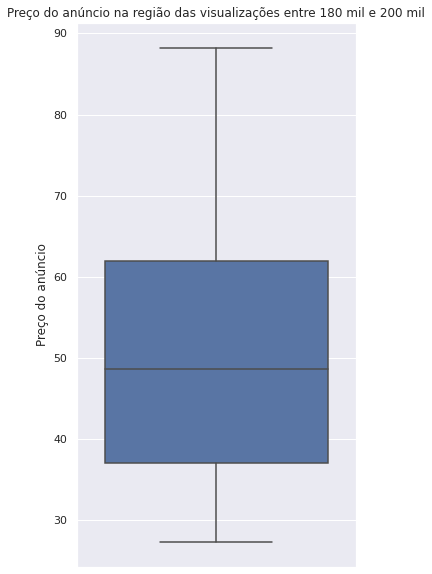

In [21]:
conclusao_1 = df[df['visualizacoes']>180000]
conclusao_1 = conclusao_1[conclusao_1['visualizacoes']<200000]

plt.figure(figsize=(5,10))
sns.boxplot(data=conclusao_1, y='preco_anuncio')
plt.title('Preço do anúncio na região das visualizações entre 180 mil e 200 mil')
plt.ylabel('Preço do anúncio')
plt.show()

Como podemos ver, na região próxima às 190 mil visualizações o preço máximo do anúncio é \$90 e a mediana de preço é próxima de \$50. Valores esses muitos distantes dos \$755. 

Abrindo a várivel 'preco_anuncio' em  função da 'interesses' na região dos 3 interesses como dito anteriormente:

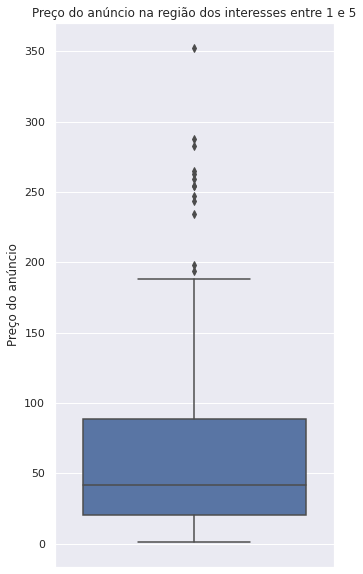

In [22]:
conclusao_2 = df[df['interesses']>1]
conclusao_2 = conclusao_2[conclusao_2['interesses']<5]

plt.figure(figsize=(5,10))
sns.boxplot(data=conclusao_2, y='preco_anuncio')
plt.title('Preço do anúncio na região dos interesses entre 1 e 5')
plt.ylabel('Preço do anúncio')
plt.show()

Como podemos ver, na região próxima aos 3 interesses o preço máximo do anúncio é \$350 e a mediana de preço é próxima de \$50. Valores esses também muitos distantes dos \$755. 

Minha conclusão final levando em consideração todos os aspectos discutidos é que o modelo não apresenta uma previsão satisfatória. Os dados base são pouco e a previsão para as condições impostas extrapola em muito os valores que vemos para as regiõs abertas acima.

Entretanto, essa experiência me trouxe muitos aprendizados e buscarei aplicar o mesmo método em bases de dados maiores com finalidades semelhantes a fim de alcançar resultados mais satisfatórios.